In [1]:
import numpy as np
import pandas as pd
import tables as tb

import invisible_cities.reco.peak_functions as rp
from invisible_cities.database import load_db

import matplotlib.pyplot as plt

import invisible_cities.reco.calib_sensors_functions as csf
from invisible_cities.types.ic_types import minmax
from invisible_cities.evm.pmaps import S1, S2

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 12, 4
font_size    = 14

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams[  "font.size"   ]  = font_size
plt.rcParams[  "image.cmap"  ]  = default_cmap
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
plt.rcParams["axes.grid"     ]  = True
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

In [3]:
def calibratedwf(wf):
    '''Given a CWF (for all PMT), it returns the total calibrated wf'''
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
#     calwf = calwfs.sum(axis=0)
    return calwf


def s1finder(wf):
    
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(0, 640)*1000
    length = minmax(4, 100)
    stride = 4
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S1
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res


def s2finder(wf):

    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(630, 1300)*1000
    length = minmax(100, 1e4)
    stride = 40
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S2
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res

# IMPORT WFS AND EVENT SUMMARY

In [4]:
#wfs
peak = 'Tl_double_escape'
wfdir  = f'./DATA/'
wffilename = f'selected_cwf_{peak}_000.h5'
file = tb.open_file(wfdir+wffilename)
wfs_by_event = file.root.BLR.pmtcwf


#evtsum
run =6482
directory = '../DATA/'
filename  = f'cepks_{run}_0000_11999_6q0min.h5'
data = pd.HDFStore(directory + filename)['/esum']


#thds
evts = np.array([x['evt_number'] for x in file.root.Run.events.iterrows()])
thds = data[np.in1d(data.event.values, evts)]

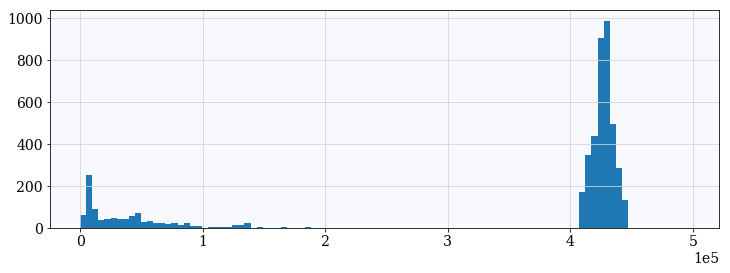

In [5]:
thds['e'].hist(bins=100);

# RECOMBINATION ENERGY

In [6]:
#Recombination energy

dt = 1 #time in microseconds

RE = []

for i in range(0, len(evts)):
    
    wfs = wfs_by_event[i]
    calwfs = calibratedwf(wfs)

    #peak finder
    #s1
    s1s = s1finder(wfs)
    if len(s1s)<1: 
        RE.append(-1)
        continue
    h = np.array([s1.height for s1 in s1s])
    idxs1 = np.argmax(h)
    s1 = s1s[idxs1]
    #s2
#     s2s = s2finder(wfs)
#     if len(s2s)<1: 
#         RE.append(-2)
#         continue
#     h = np.array([s2.height for s2 in s2s])
#     idxs2 = np.argmax(h)
#     s2 = s2s[idxs2]
    try:
        s2 = s2finder(wfs)[0]
    except IndexError:
        RE.append(-2)
        continue
    
    #energy
    s1tim = s1.times/1000
    s2tim = s2.times/1000
    
    t = np.arange(len(wfs.sum(axis=0)))/40
    idx = np.argwhere((s1tim[-1]+dt<=t) & (t<= s2tim[0]-dt)).flatten()
    
    #sum
    calwfs_RE = calwfs[:, idx]
    RE.append(calwfs_RE.sum())
    
    print(f'Proccessed {i+1}/{len(evts)}', end='\r')
    
RE = np.array(RE)

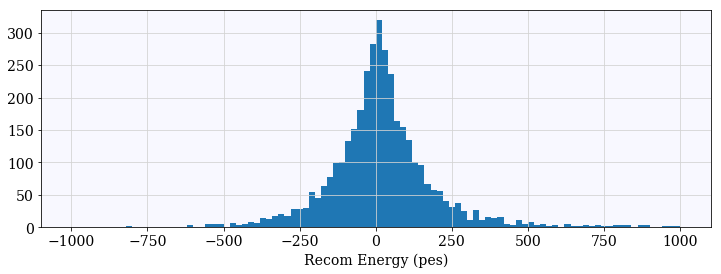

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)

rg = (-1e3, 1e3)
ax.hist(RE, bins=100, range = rg)
ax.set_xlabel('Recomb Energy (pes)');

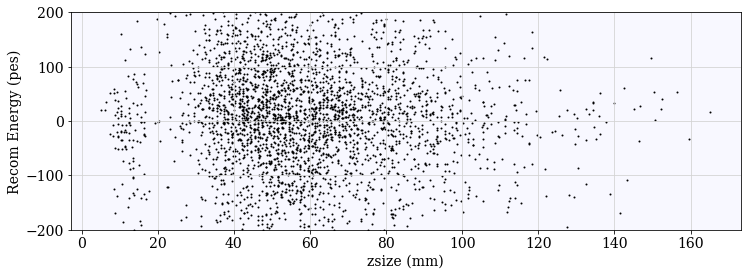

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)

# ax.hist2d(thds[thds.peak==0].zsize, RE)
ax.scatter(thds[thds.peak==0].zsize, RE, s=1, c='black')

ax.set_xlabel('zsize (mm)')
ax.set_ylabel('Recomb Energy (pes)');

ax.set_ylim(-2e2, 2e2);
# ax.set_xlim(20, 120);

In [83]:
cut = 1e5
ipos = np.argwhere(RE>cut).flatten()

i = ipos[int(np.random.random()*len(ipos))]
wfs = wfs_by_event[i]
calwfs = calibratedwf(wfs)

print(f'Recomb energy cut: {cut}')
print()
print(f'Number of events: {len(ipos)}')
print()
print(f'Event to study: {evts[i]}')
print()

Recomb energy cut: -500.0

Number of events: 51

Event to study: 2646060



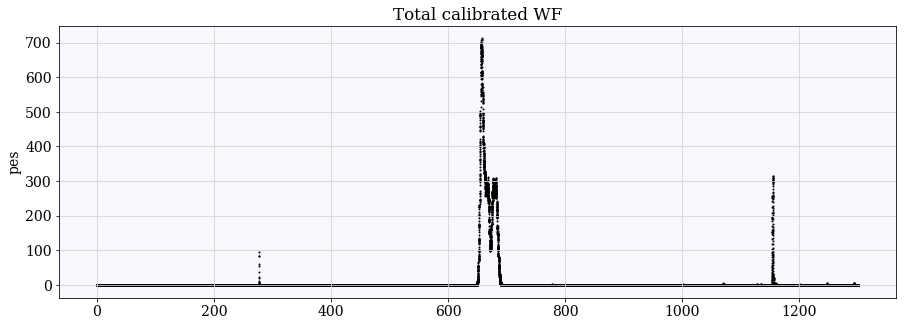

In [84]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('Total calibrated WF')
ax.scatter(t, calwfs.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');

# ax.set_xlim(650, 720);
# ax.set_ylim(-50, 50);

In [85]:
s1s = s1finder(wfs) 
h = np.array([s1.height for s1 in s1s])
idxs1 = np.argmax(h)
s1 = s1s[idxs1]

s2 = s2finder(wfs)[0]

s1tim = s1.times/1000
s2tim = s2.times/1000

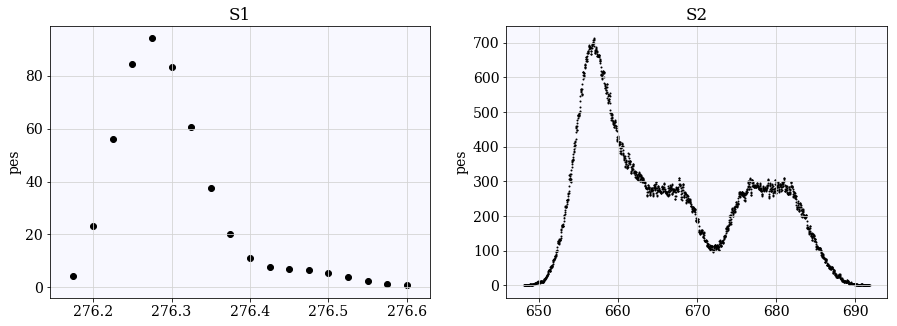

In [86]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(121)
ax.set_title('S1')
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black')
ax.set_ylabel('pes')

ax = fig.add_subplot(122)
ax.set_title('S2')
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black', s=1)
ax.set_ylabel('pes');

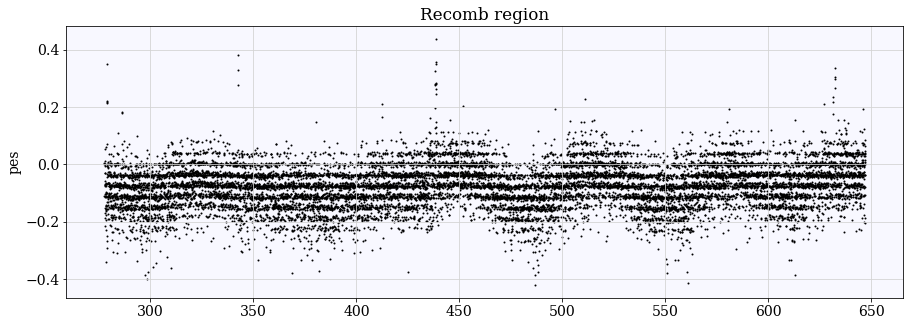

In [87]:
idx = np.argwhere((s1tim[-1]+dt<=t) & (t<= s2tim[0]-dt)).flatten()
    
#sum
calwfs_RE = calwfs[:, idx]

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('Recombination region')
ax.scatter(t[idx], calwfs_RE.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');